In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Resources :

- https://chrisorm.github.io/VI-MC-PYT.html
- https://pdfs.semanticscholar.org/e407/ea7fda6d152d2186f4b5e27aa04ec2d32dcd.pdf

## Variationnal Inference

<img src="VI.png">

We introduce a new approximation function  $q_\phi(\mathbf{z}\vert\mathbf{x})$, parameterized by $\phi$  within a tractable parametric family such that $q(\mathbf{z}\vert\mathbf{x})= q(\mathbf{z}\vert\mathbf{x}, \phi^{*})$ ;
$\phi^{*} = \operatorname*{argmin}_\phi KL(q(\mathbf{z}\vert\mathbf{x}, \phi) || p(\mathbf{z}\vert\mathbf{x}) )$ and the evidence lower bound (**ELBO**) is defined by :



\begin{align*}
\mathcal{L} &= \mathbb{E}_q\big[ \log{p(x,z)} - \log{q_\phi(z)} \big] \\
&= \mathbb{E}_q\big[ \log{p(x|z)} \big] - KL(q(z)||p(z)) 
\end{align*}

### Basic VI (CAVI)

Mean-field variational family, where the latent variables are mutually independant :

$$q(\mathbf{z}) = \prod_{j} q_j(z_j)$$

##### Example

See Gaussian Mixtures example. https://github.com/ineskris/VI/blob/master/VI-GaussianMixtures%20.ipynb

### Black Box VI

Idea = write the gradient of the ELBO as an expectation, compute MC estimates of it, and then use stochastic optimization with repeated MC gradients.

https://arxiv.org/abs/1401.0118

<img src="BBVI.png">

$$ \nabla_{\phi} \mathcal{L} = \mathbb{E}_{q_{\phi}}\big[ \nabla_{\phi}\log{q( z, \phi)} (\log{p( z, x)}  - \log{q( z, \phi)})] $$

https://www.cs.toronto.edu/~duvenaud/papers/blackbox.pdf

#### Example  Logistic Regression

$X \in \cal{R}^{n \times p }$ with binary outputs $y_i \in \cal{R}^{n}$

\begin{align} p(\mathbf{y_i} \vert \mathbf{z_i}, \mathbf{x}) \sim \cal{B}(\sigma(z'x_i)) \end{align} where $\sigma$ is the inverse logit function and z from p-dimensional multivariate normal with independent components.

We want : $$p(z\vert X, y)$$

We choose a variational distribution over z, (Mean field approximation): 


$$q(\mathbf{z} \vert \phi) = \prod_{j} q_j(z_j)$$ 

Here, we use :

$$q(\mathbf{z} \vert \phi) = \prod_{j} \cal{N}(z_j \vert \mu_{j} , \sigma_{j}^{2} )$$ 

We model each $z_j$ as an independent Gaussian with mean $μ_{j}$ and $\sigma_{j}^{2}$, and we use BBVI to learn the optimal values of $\phi= (μ_{j}, \sigma_{j}^{2})$

#### Evaluate the score $\nabla q(\mathbf{z} \vert \phi) $

$\nabla_{ \mu_{j}} \log q(\mathbf{z} \vert \phi) =\nabla_{ \mu_{i}} \sum_i -\dfrac{\log{(2\pi\sigma_{i}^{2})}}{2}  -\dfrac{(z_i-\mu_i)^2}{2\sigma_{i}^{2}} = \dfrac{(z_j-\mu_j)}{\sigma_{j}^{2}}   $


We use $ \alpha_{j}= \log (2 \pi \sigma_{j}^{2}) $


$\nabla_{\alpha_{j}} \log q(\mathbf{z} \vert \phi) = \nabla_{ \alpha_{j}} \sum_i-\dfrac{\alpha_{j}}{2}   -\dfrac{(z_i-\mu_i)^2 \pi}{\exp \alpha_{j}} = -
\dfrac{1}{2} +  \dfrac{(z_j-\mu_j)^2}{2\sigma_{j}^{2}}  $



#### Evaluate joint distribution $\log p(y, X, z) = \log{p(y \vert X, z)} + \log p(z) $

$\log p(y, X, z) = \sum_i [y_{i} \log (\sigma (z' x_{i})) + (1 - y_{i}) \log (1 - \sigma (z' x_{i})) + \sum_i \log \psi(z_{j} \vert 0,1)  $


where 

$\psi$ is the standard normal pdf.\

#### Evaluate $log q(\mathbf{z} \vert \phi) =   \sum_i \psi(z_{i} \vert \mu_{i},  \sigma_{i}^{2})  $

#### Evaluate the learning rate $\rho$

http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf

Let Gt be a matrix containing the sum across the first t iterations of the outer products of the gradient. AdaGrad defines a per component learning rate as
$\rho_t = η diag(Gt)^{-1/2}$


### BBVI code

#### With Python

In [2]:
# Simulation
from scipy.special import expit as sigmoid
from scipy.stats import norm
n = 100
p = 4
X = np.random.randn(n,p) #standard normal distribution
z_real = np.random.randn(p)
y = np.random.binomial(1,sigmoid(np.dot(X,z_real)),n)

In [3]:
sigmoid(np.dot(X,z_real)).shape

(100,)

In [4]:
#Gradient_ELBO
def elbo_grad(z_samp, mu, sigma):
    grad_mu = (z_samp - mu)/(sigma)
    grad_logsigma = -1/2+ (z_samp - mu)**2/(2*sigma)
    
    log_p = np.sum(y * np.log(sigmoid(np.dot(X,z_samp))) + (1-y) * np.log(1-sigmoid(np.dot(X,z_samp))))+ np.sum(norm.logpdf(z_samp, np.zeros(p), np.ones(p)))
    log_q = np.sum(norm.logpdf(z_samp, mu, sigma))
    
    return np.concatenate([grad_mu,grad_logsigma])*(log_p - log_q) #len = 2xp for mu and sigma 

In [5]:
#BBVI
n_iter = 1000
samp_number = 30

#initialization
mu = np.random.randn(p)
log_sigma = np.random.randn(p)
mus = np.zeros((n_iter,p))
eta = 0.1
G = np.zeros((2*p,2*p))


for t in np.arange(n_iter):
    mus[t] = mu
    sigma = np.exp(log_sigma)
    
    #sample from q 
    samples = np.array([np.random.normal(mu, np.sqrt(sigma)) for s in np.arange(samp_number)])
    
    #monte carlo estimator 
    grad_estimate = np.mean(np.array([elbo_grad(samp, mu, sigma) for samp in samples]),axis=0)
   
    #adagrad optimization 
    G =  G+np.outer(grad_estimate,grad_estimate) 
 
    #update 
    mu_new = mu + (eta * 1/np.sqrt(np.diag(G)))[:p] * grad_estimate[:p]
    
    log_sigma_new = log_sigma + (eta * 1/np.sqrt(np.diag(G)))[p:] * grad_estimate[p:]
    
    
    if np.linalg.norm(mu_new-mu) < 0.001:
        break
    mu, log_sigma = mu_new, log_sigma_new
    



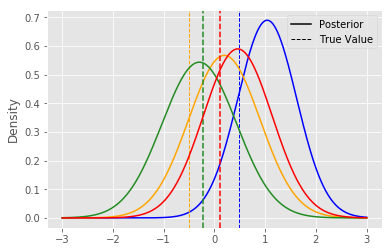

In [6]:
x = np.linspace(-3, 3, 1000)
plt.plot(x,norm.pdf(x, mu[0], np.sqrt(sigma[0])),"blue",label="Posterior")
plt.axvline(x=z_real[0],c="blue",linestyle='dashed',linewidth=1,label="True Value")
plt.plot(x,norm.pdf(x, mu[1], np.sqrt(sigma[1])),c="orange")
plt.axvline(x=z_real[1],c="orange",linestyle='dashed',linewidth=1)
plt.plot(x,norm.pdf(x, mu[2], np.sqrt(sigma[2])),c="forestgreen")
plt.axvline(x=z_real[2],c="forestgreen",linestyle='dashed')
plt.plot(x,norm.pdf(x, mu[3], np.sqrt(sigma[3])),c="red")
plt.axvline(x=z_real[3],c="red",linestyle='dashed')
plt.ylabel("Density")
leg = plt.legend(loc=1)
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')

In [7]:
nb_iter = t

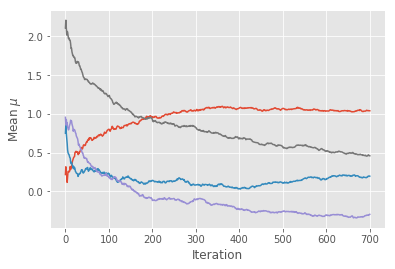

In [8]:
plt.plot(range(nb_iter +1),mus[:(t+1)])
plt.xlabel("Iteration")
plt.ylabel("Mean $\mu$");

#### Using AdaGrad optimizer

In [9]:
from torch.autograd import Variable
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import *
from torch.distributions.utils import probs_to_logits, logits_to_probs
from torch.nn.functional import binary_cross_entropy_with_logits

In [10]:
# Simulation
from scipy.special import expit as sigmoid
from scipy.stats import norm
n = 1000
p = 4
X = np.random.randn(n,p) #standard normal distribution
z_real =  np.array([-1, 3,  -3, -2])
y = np.random.binomial(1,sigmoid(np.dot(X,z_real)),n)

In [11]:
z_real

array([-1,  3, -3, -2])

In [14]:
class bbvi(torch.nn.Module):
    '''
    X : Tensor nxp given
    y : Tensor n given
    z : Tensor s x p (s=number of sample , z~q(z|y,x) distribution)
    
    '''
    def __init__(self, p=4, s=30):
        self.p = p
        self.s = s

        super(bbvi, self).__init__()
        # mu and sigma of q distrib
        self.mu = torch.nn.Parameter(torch.randn(1,p), requires_grad=True)
        self.logsigma = torch.nn.Parameter(torch.randn(1,p), requires_grad=True)
        
        self.sigmoid = torch.nn.Sigmoid()
        
        #prior
        self.prior_m = Variable(torch.zeros(1,p), requires_grad=False)
        self.prior_log_sigma = Variable(torch.ones(1,p), requires_grad=False)
        

        
    def gen_sample(self):
        return(torch.randn(self.s,p))
    
    def reparam(self, eps):
        eps = Variable(torch.FloatTensor(eps))
        sigma = self.logsigma.exp()
        return  eps.mul(sigma).add(self.mu)
    
    def compute_elbo(self, X, y ):
        eps = self.gen_sample()
        z = self.reparam(eps) 
  
        sigma = self.logsigma.exp()
        prior_sigma =self.prior_log_sigma.exp()


       
        q_log_likelihood = Normal(self.mu,sigma).log_prob(z).sum(0).mean()


    
        log_prior =  Normal(self.prior_m, prior_sigma).log_prob(z).sum(0).mean()

        kld = q_log_likelihood - log_prior

        
        mult = torch.matmul(X,z.transpose(0,1)) #return a vector nxs 
        multmean = mult.mean(1) #return a vector nx1
        sigmoid = self.sigmoid(multmean) #return a vector nx1
        
        print(binary_cross_entropy_with_logits(sigmoid, y, reduction ='mean'))
        print(binary_cross_entropy_with_logits(sigmoid, y, reduction ='sum'))
        print(binary_cross_entropy_with_logits(sigmoid, y, reduction ='sum').mean())
        
        loglike = - binary_cross_entropy_with_logits(sigmoid, y, reduction ='sum')
                                                                            
      
        elbo = loglike - kld
        
        return elbo
    

   

In [15]:
bb = bbvi()
optimizer = torch.optim.Adagrad(bb.parameters(),lr=0.2) #lr = learning rate lr 

# input as Tensor
X =  Variable(torch.Tensor(X), requires_grad=False) 
y = Variable(torch.Tensor(y), requires_grad=False)

for i in range(1000):
    loss = -bb.compute_elbo(X, y)
    # clear out the gradients of all Variables in this optimizer (i.e. W, b)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    # compute dloss/dx for mu and sigma 
    optimizer.step()
    # update the parameters
    
#     if i % 400 ==0:
#         print(bb.mu.data.numpy())
#         print(loss)

tensor(0.6984, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(698.3737, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(698.3737, grad_fn=<MeanBackward0>)
tensor(0.6736, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(673.5952, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(673.5952, grad_fn=<MeanBackward0>)
tensor(0.6675, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(667.4755, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(667.4755, grad_fn=<MeanBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(636.7698, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(636.7698, grad_fn=<MeanBackward0>)
tensor(0.6399, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(639.9205, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(639.9205, grad_fn=<MeanBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(638.0390, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(638.0390, grad_

tensor(0.5723, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(572.2983, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(572.2983, grad_fn=<MeanBackward0>)
tensor(0.5696, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(569.5867, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(569.5867, grad_fn=<MeanBackward0>)
tensor(0.5672, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(567.1522, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(567.1522, grad_fn=<MeanBackward0>)
tensor(0.5687, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(568.6544, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(568.6544, grad_fn=<MeanBackward0>)
tensor(0.5669, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.8844, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.8844, grad_fn=<MeanBackward0>)
tensor(0.5703, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(570.2902, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(570.2902, grad_

tensor(0.5659, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(565.8901, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(565.8901, grad_fn=<MeanBackward0>)
tensor(0.5669, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.8832, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.8832, grad_fn=<MeanBackward0>)
tensor(0.5616, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.6282, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.6282, grad_fn=<MeanBackward0>)
tensor(0.5675, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(567.4894, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(567.4894, grad_fn=<MeanBackward0>)
tensor(0.5697, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(569.7118, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(569.7118, grad_fn=<MeanBackward0>)
tensor(0.5635, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(563.5112, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(563.5112, grad_

tensor(0.5609, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.8538, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.8538, grad_fn=<MeanBackward0>)
tensor(0.5650, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(564.9539, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(564.9539, grad_fn=<MeanBackward0>)
tensor(0.5593, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.3062, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.3062, grad_fn=<MeanBackward0>)
tensor(0.5617, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.6798, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.6798, grad_fn=<MeanBackward0>)
tensor(0.5667, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.6909, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.6909, grad_fn=<MeanBackward0>)
tensor(0.5652, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(565.2053, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(565.2053, grad_

tensor(0.5664, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.3987, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.3987, grad_fn=<MeanBackward0>)
tensor(0.5661, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.1216, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.1216, grad_fn=<MeanBackward0>)
tensor(0.5617, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.7076, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.7076, grad_fn=<MeanBackward0>)
tensor(0.5664, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.4434, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.4434, grad_fn=<MeanBackward0>)
tensor(0.5583, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(558.3195, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(558.3195, grad_fn=<MeanBackward0>)
tensor(0.5592, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.1805, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.1805, grad_

tensor(0.5593, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.3476, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.3476, grad_fn=<MeanBackward0>)
tensor(0.5626, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(562.6172, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(562.6172, grad_fn=<MeanBackward0>)
tensor(0.5586, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(558.5919, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(558.5919, grad_fn=<MeanBackward0>)
tensor(0.5636, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(563.5665, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(563.5665, grad_fn=<MeanBackward0>)
tensor(0.5664, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.3749, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(566.3749, grad_fn=<MeanBackward0>)
tensor(0.5604, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.4332, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.4332, grad_

tensor(0.5695, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(569.4734, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(569.4734, grad_fn=<MeanBackward0>)
tensor(0.5617, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.7095, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.7095, grad_fn=<MeanBackward0>)
tensor(0.5750, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(574.9700, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(574.9700, grad_fn=<MeanBackward0>)
tensor(0.5606, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.5709, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.5709, grad_fn=<MeanBackward0>)
tensor(0.5602, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.2491, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.2491, grad_fn=<MeanBackward0>)
tensor(0.5605, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.4893, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.4893, grad_

tensor(559.9337, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.9337, grad_fn=<MeanBackward0>)
tensor(0.5647, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(564.7457, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(564.7457, grad_fn=<MeanBackward0>)
tensor(0.5671, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(567.0607, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(567.0607, grad_fn=<MeanBackward0>)
tensor(0.5568, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(556.8014, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(556.8014, grad_fn=<MeanBackward0>)
tensor(0.5607, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.6968, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(560.6968, grad_fn=<MeanBackward0>)
tensor(0.5656, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(565.5633, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(565.5633, grad_fn=<MeanBackward0>)
tensor(0.5633, grad_fn=<BinaryCrossEntropyW

tensor(0.5577, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(557.6693, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(557.6693, grad_fn=<MeanBackward0>)
tensor(0.5613, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.2670, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.2670, grad_fn=<MeanBackward0>)
tensor(0.5619, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.8986, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(561.8986, grad_fn=<MeanBackward0>)
tensor(0.5547, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(554.7219, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(554.7219, grad_fn=<MeanBackward0>)
tensor(0.5624, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(562.4099, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(562.4099, grad_fn=<MeanBackward0>)
tensor(0.5583, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(558.2922, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(558.2922, grad_

tensor(0.5680, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(568.0308, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(568.0308, grad_fn=<MeanBackward0>)
tensor(0.5579, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(557.9079, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(557.9079, grad_fn=<MeanBackward0>)
tensor(0.5584, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(558.3813, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(558.3813, grad_fn=<MeanBackward0>)
tensor(0.5571, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(557.1381, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(557.1381, grad_fn=<MeanBackward0>)
tensor(0.5596, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.5715, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.5715, grad_fn=<MeanBackward0>)
tensor(0.5597, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.6749, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(559.6749, grad_

In [16]:
mu = bb.mu.data.numpy()
mu

array([[-1.1493038,  3.2395477, -3.3033473, -2.0638819]], dtype=float32)

In [17]:
sigma = bb.logsigma.exp().data.numpy()
sigma[0][0]

2.3623056

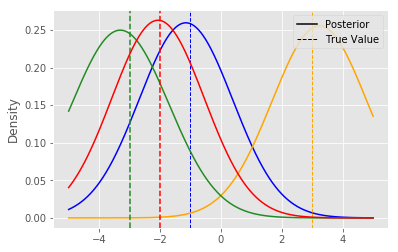

In [18]:
x = np.linspace(-5, 5, 1000)
plt.plot(x,norm.pdf(x, mu[0][0], np.sqrt(sigma[0][0])),"blue",label="Posterior")
plt.axvline(x=z_real[0],c="blue",linestyle='dashed',linewidth=1,label="True Value")
plt.plot(x,norm.pdf(x, mu[0][1], np.sqrt(sigma[0][1])),c="orange")
plt.axvline(x=z_real[1],c="orange",linestyle='dashed',linewidth=1)
plt.plot(x,norm.pdf(x, mu[0][2], np.sqrt(sigma[0][2])),c="forestgreen")
plt.axvline(x=z_real[2],c="forestgreen",linestyle='dashed')
plt.plot(x,norm.pdf(x, mu[0][3], np.sqrt(sigma[0][3])),c="red")
plt.axvline(x=z_real[3],c="red",linestyle='dashed')
plt.ylabel("Density")
leg = plt.legend(loc=1)
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')